# scRNA-seq analysis tutorial -- COMPLETE

from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [107]:
import pandas as pd
import scanpy as sc

In [108]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.3 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [109]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

In [110]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [111]:
adata.var_names_make_unique()

In [112]:
adata #confirmed dimensions match the tutorial

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


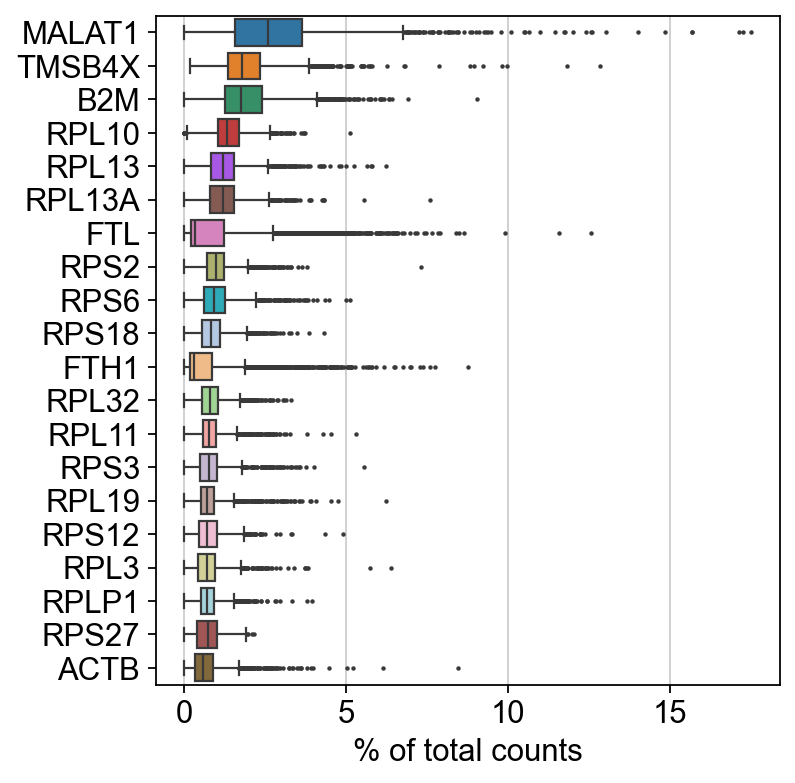

In [113]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [114]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 19024 genes that are detected in less than 3 cells


In [115]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

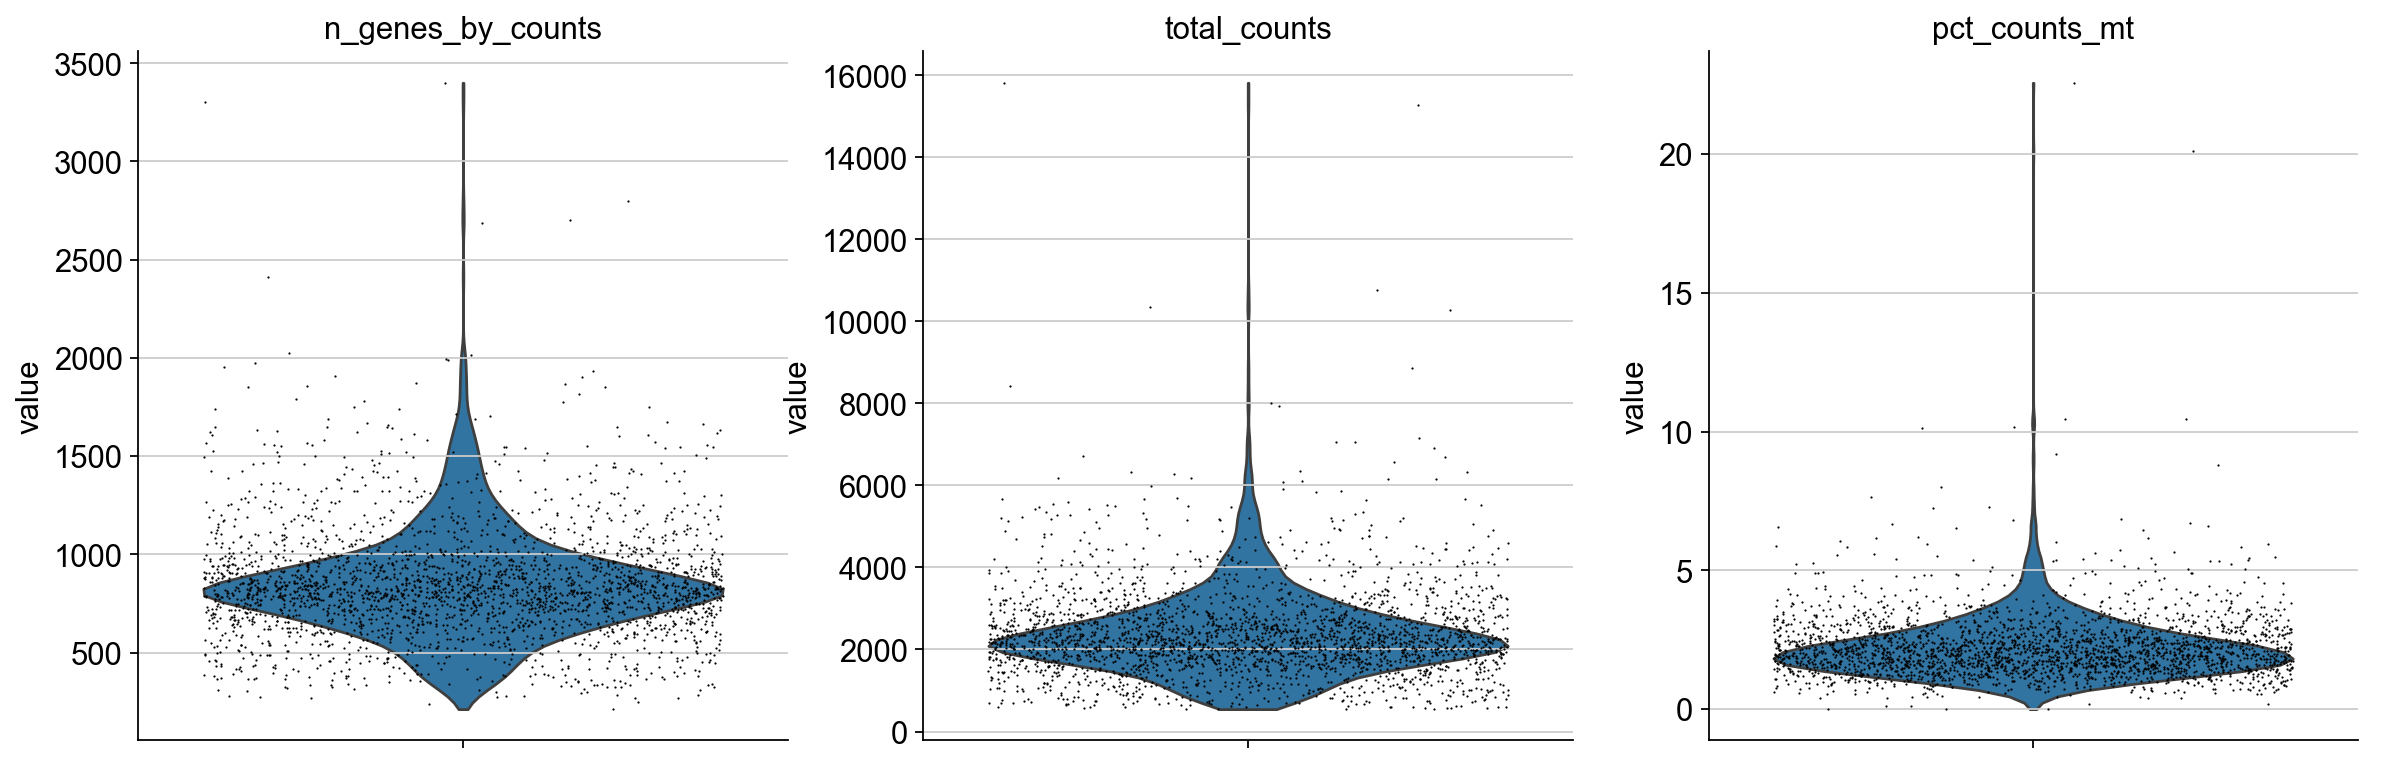

In [116]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


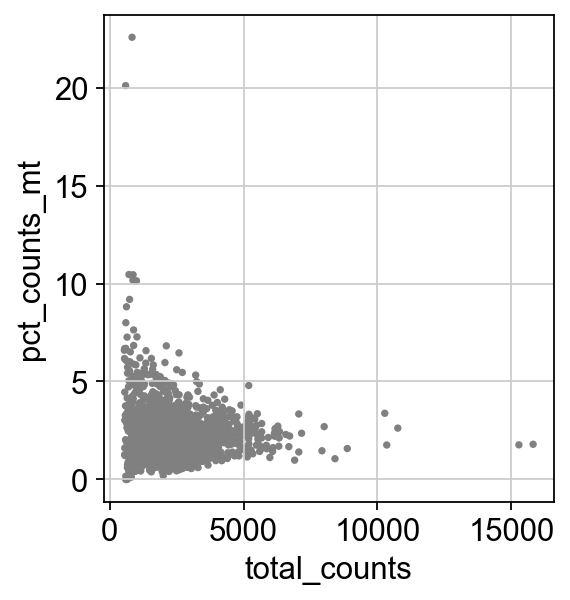

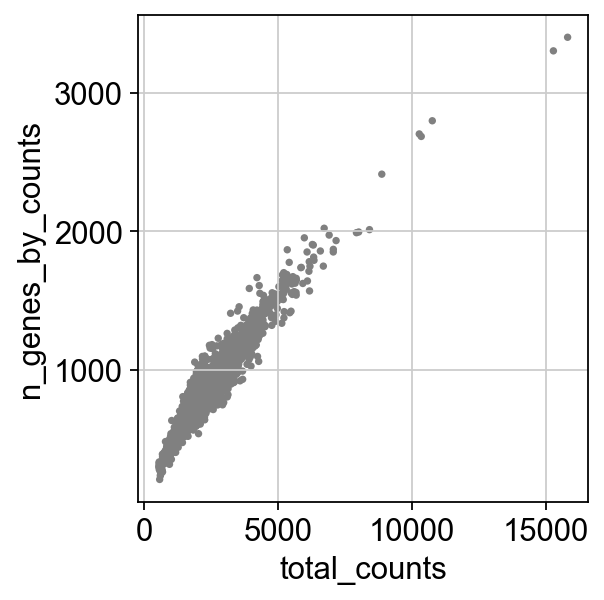

In [117]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [118]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [119]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [120]:
sc.pp.log1p(adata)

In [121]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


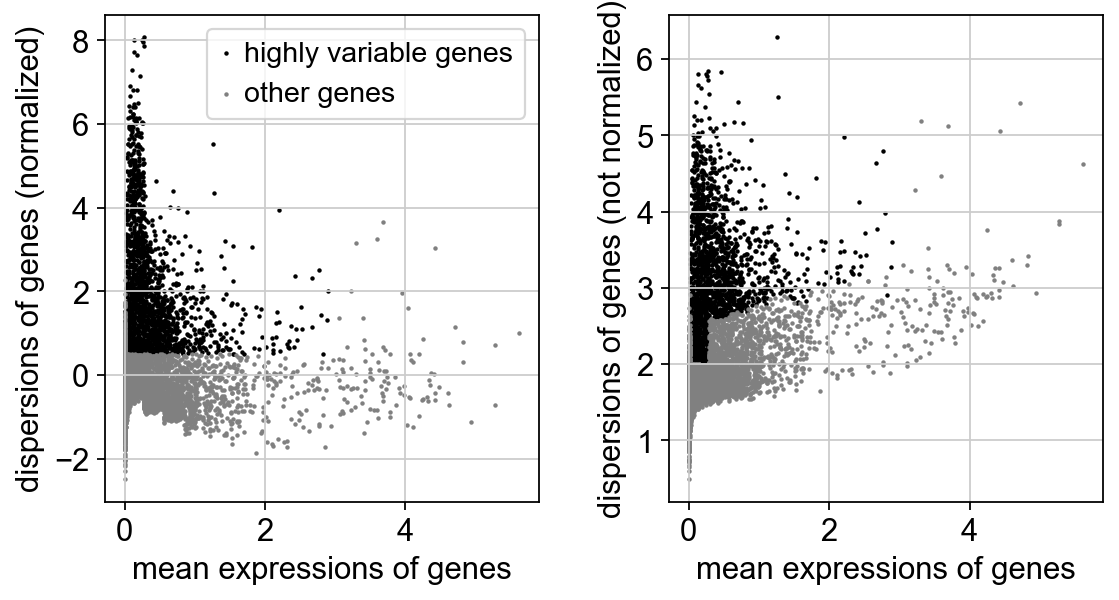

In [122]:
sc.pl.highly_variable_genes(adata)

In [123]:
adata.raw = adata

In [124]:
adata = adata[:, adata.var.highly_variable]

In [125]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


In [126]:
sc.pp.scale(adata, max_value=10)

In [127]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


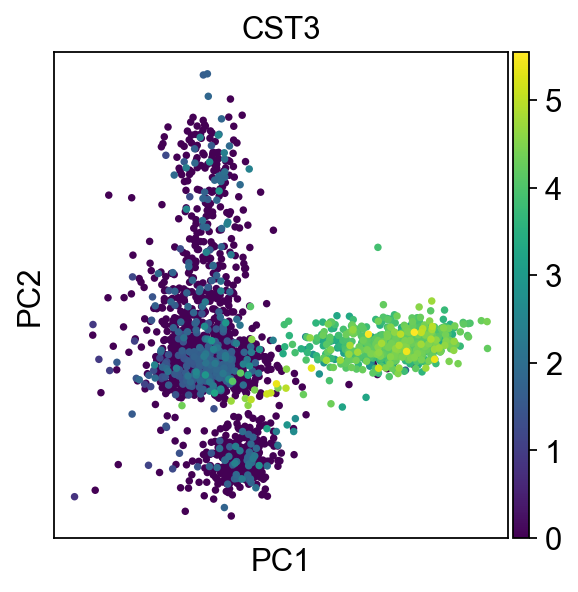

In [128]:
sc.pl.pca(adata, color="CST3")

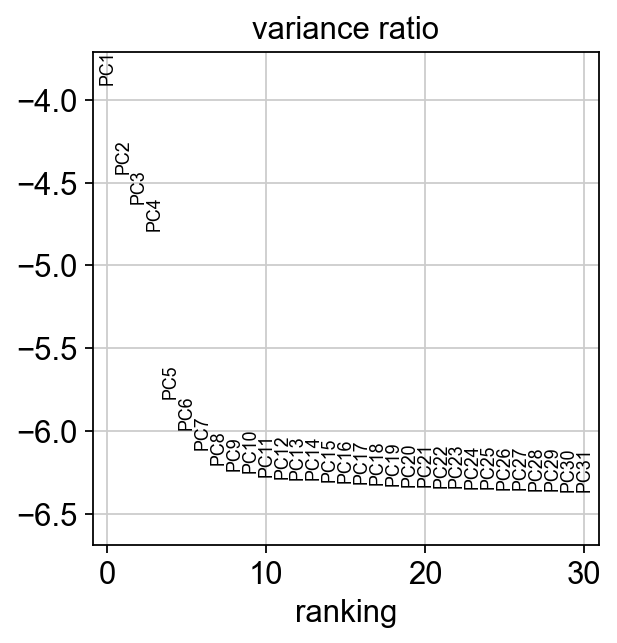

In [129]:
sc.pl.pca_variance_ratio(adata, log=True)

In [130]:
adata.write(results_file)
adata #confirms matches up to this point as well

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [131]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [132]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


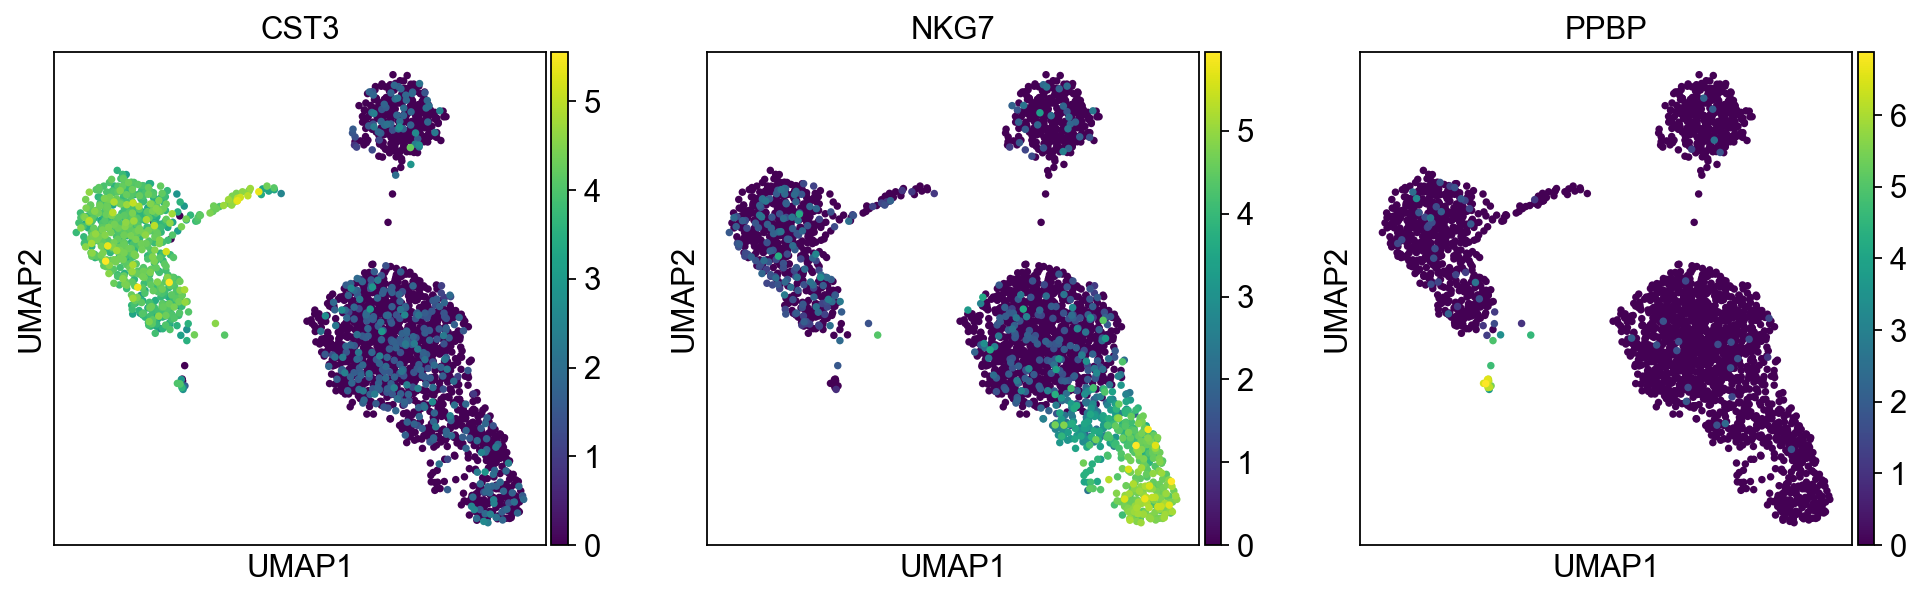

In [133]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

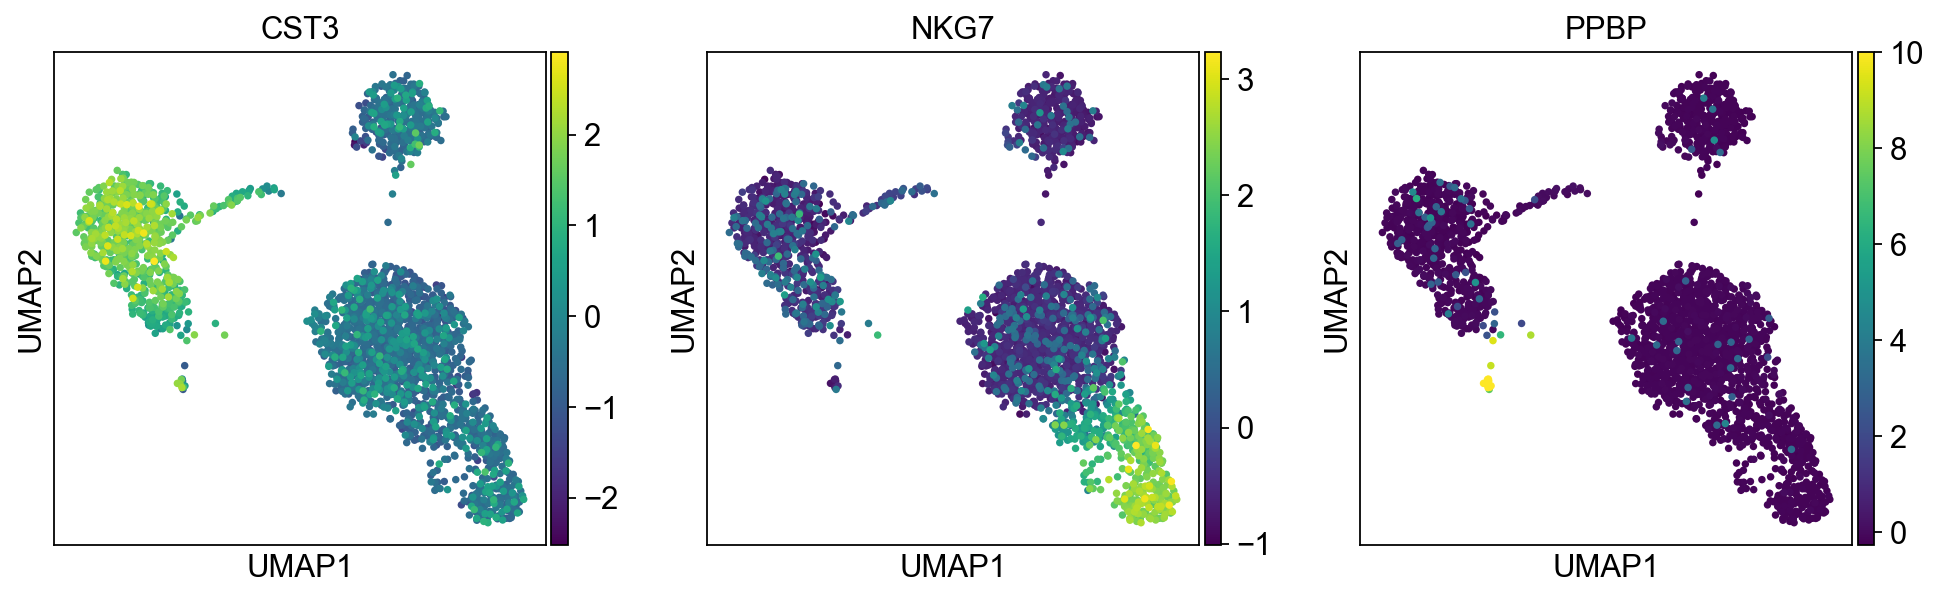

In [134]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

In [135]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


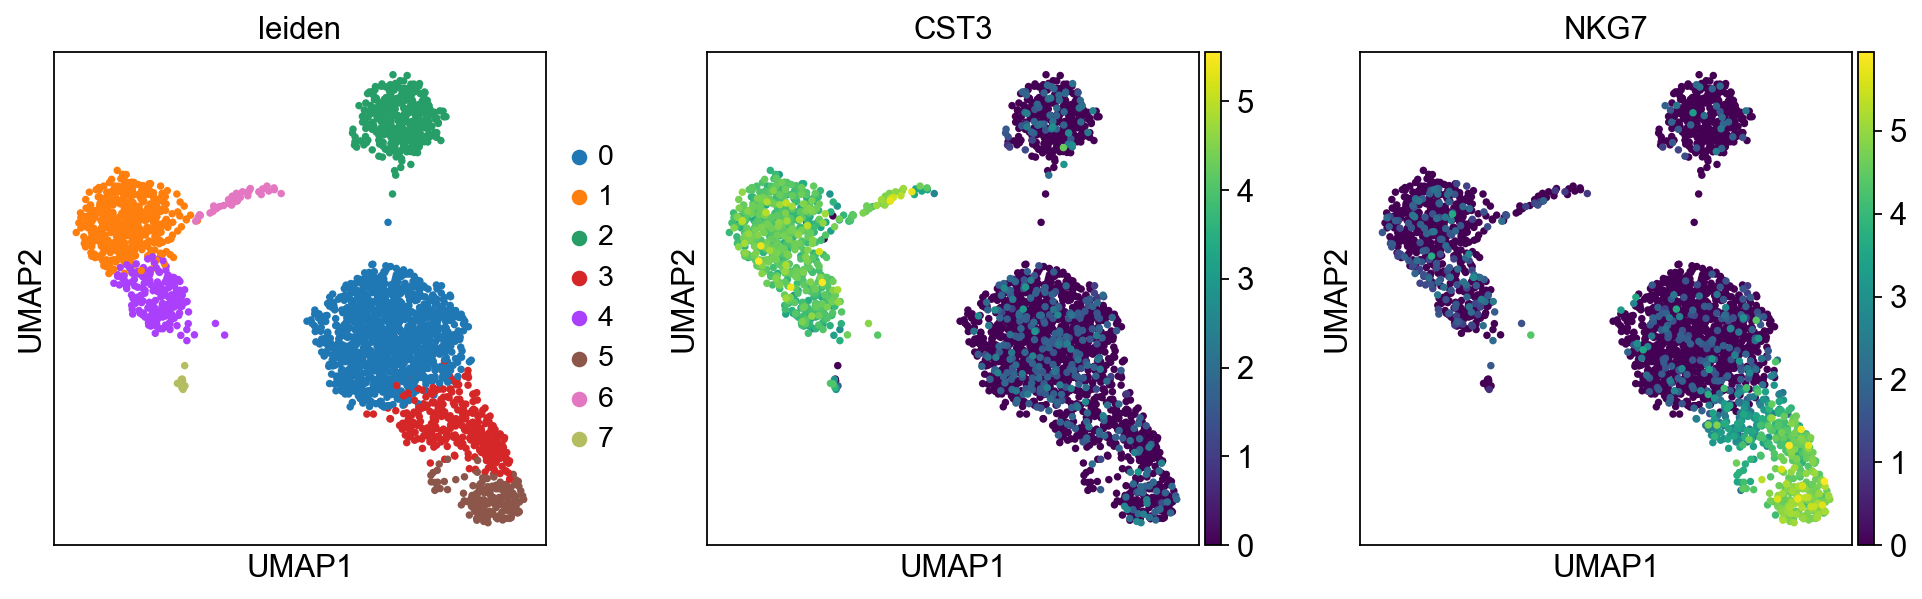

In [136]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"]) #same shapes but clusters are numbered differently

In [137]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


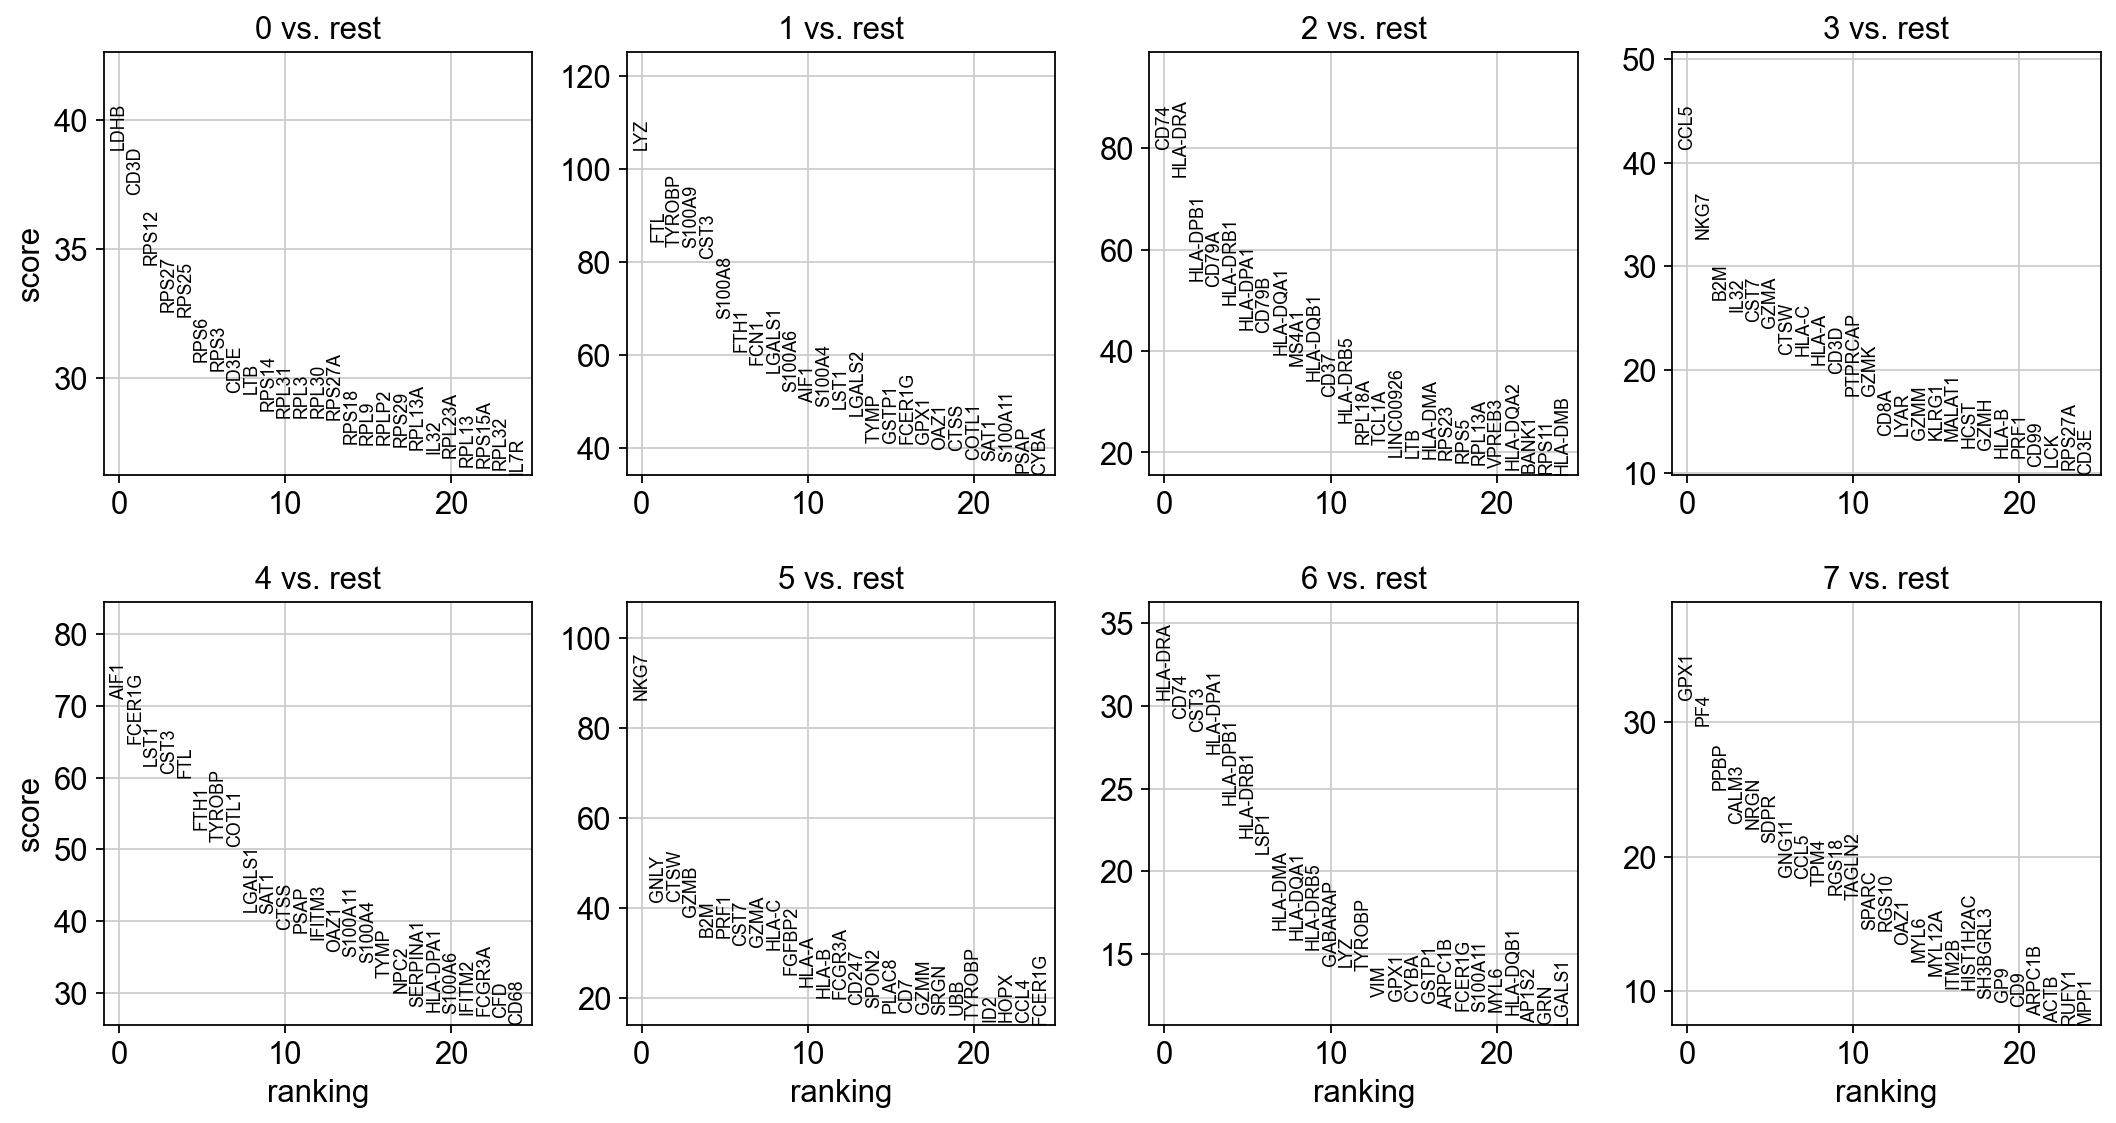

In [138]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [139]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:01)


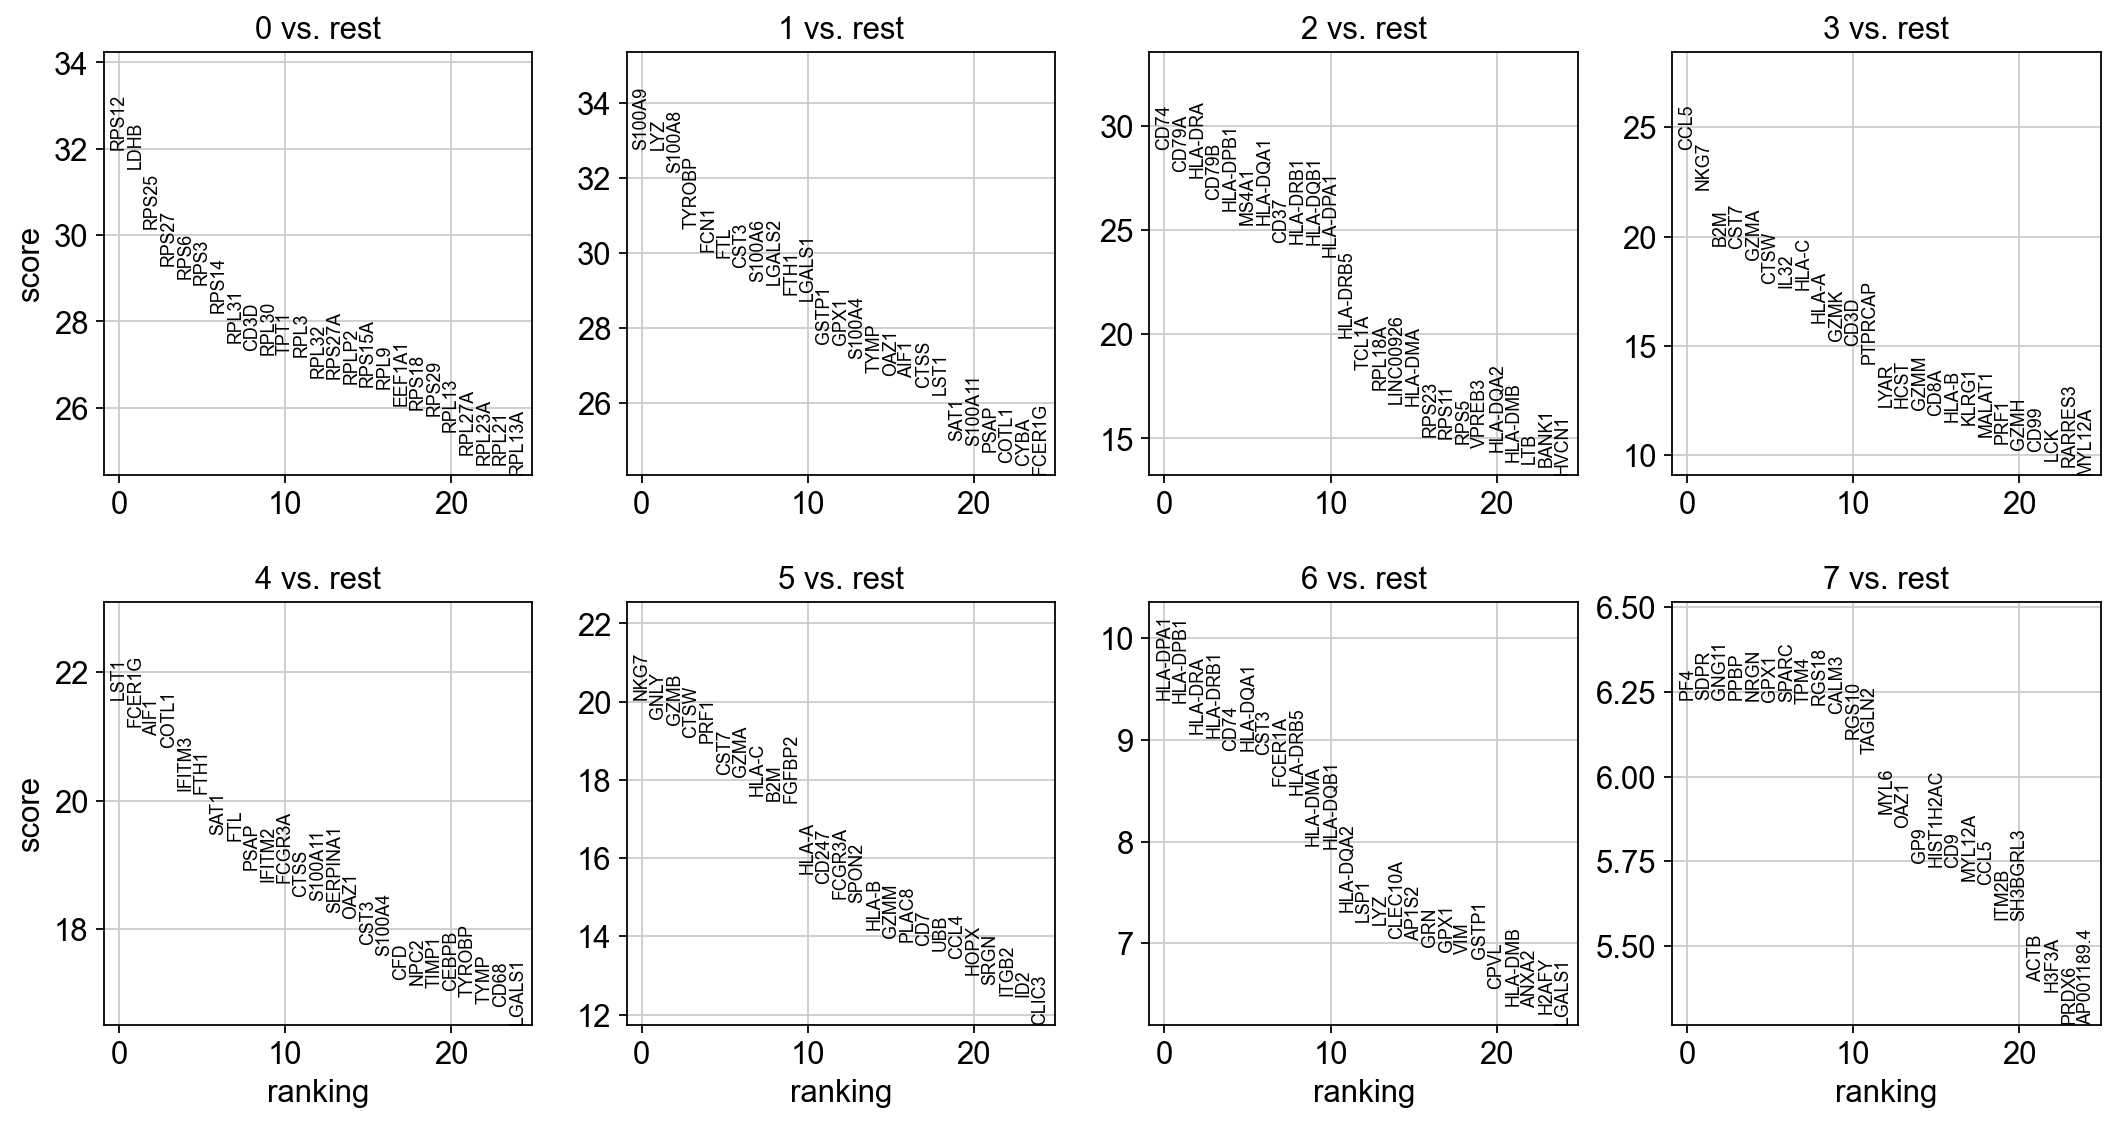

In [140]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [141]:
adata.write(results_file)

In [142]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [143]:
adata = sc.read(results_file)

In [144]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,IFITM3,PRF1,CD74,NRGN


In [145]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,1.643866e-224,S100A9,2.224833e-235,CD74,2.487145e-183,CCL5,3.743801e-127,LST1,2.860351e-103,NKG7,1.547655e-89,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,1.615960e-218,LYZ,2.665315e-235,CD79A,1.679730e-170,NKG7,6.946433e-109,FCER1G,2.722059e-99,GNLY,2.663269e-85,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,8.587781e-200,S100A8,1.010233e-226,HLA-DRA,6.949695e-167,B2M,1.173834e-85,AIF1,5.291049e-98,GZMB,5.388204e-84,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,8.390837e-189,TYROBP,1.614537e-206,CD79B,2.569135e-154,CST7,3.517553e-84,COTL1,2.746763e-96,CTSW,4.218124e-81,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,5.391220e-185,FCN1,3.533003e-198,HLA-DPB1,3.580735e-148,GZMA,5.818849e-80,IFITM3,2.571122e-90,PRF1,3.301557e-80,CD74,5.853161e-19,NRGN,4.800511e-10


ranking genes
    finished (0:00:00)


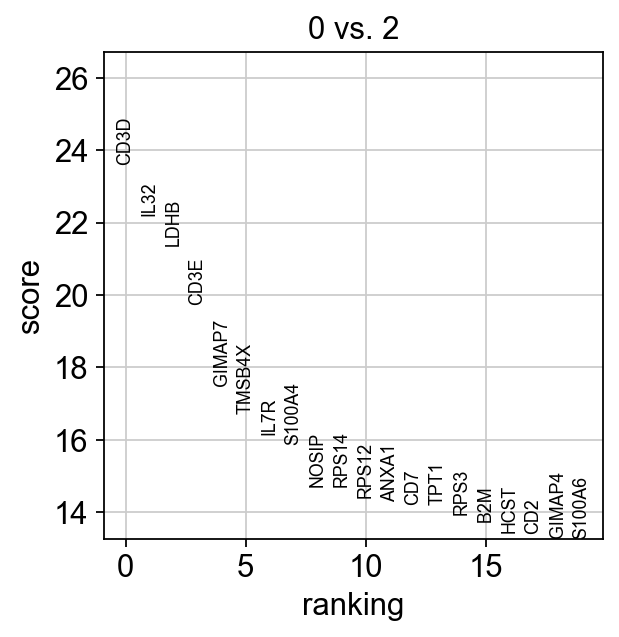

In [146]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="2", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20) #genes don't agree b/c groups numbered differently for 0,1,2... fixed by changing reference to be 2

/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


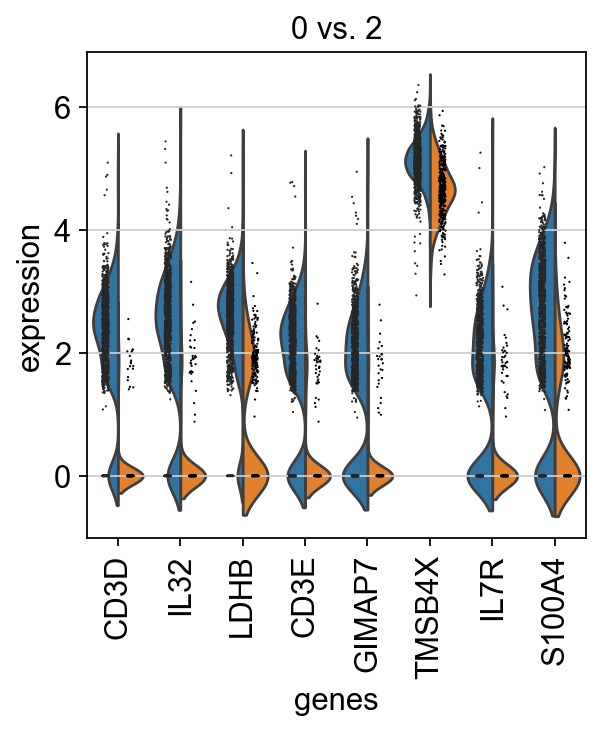

In [147]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8) #genes don't agree... why?

In [148]:
adata = sc.read(results_file)

/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1170: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  _ax = sns.violinplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1183: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  _ax = sns.stripplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


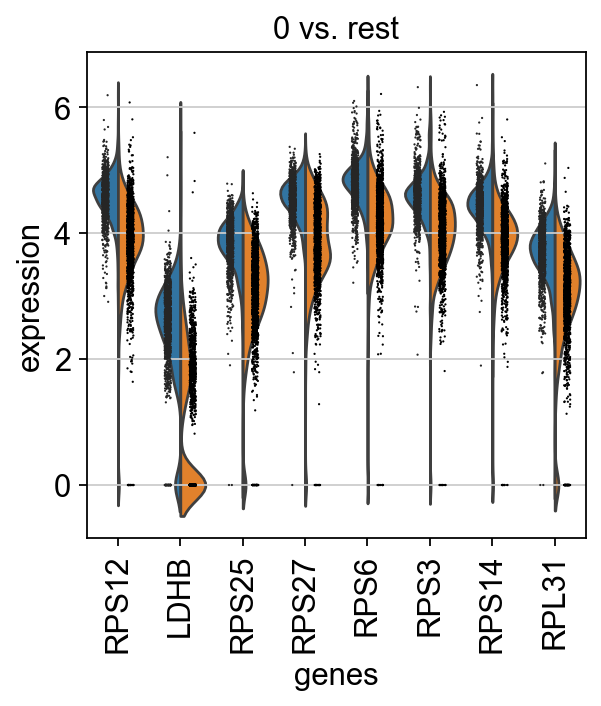

In [149]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8) #this agrees now

/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed 

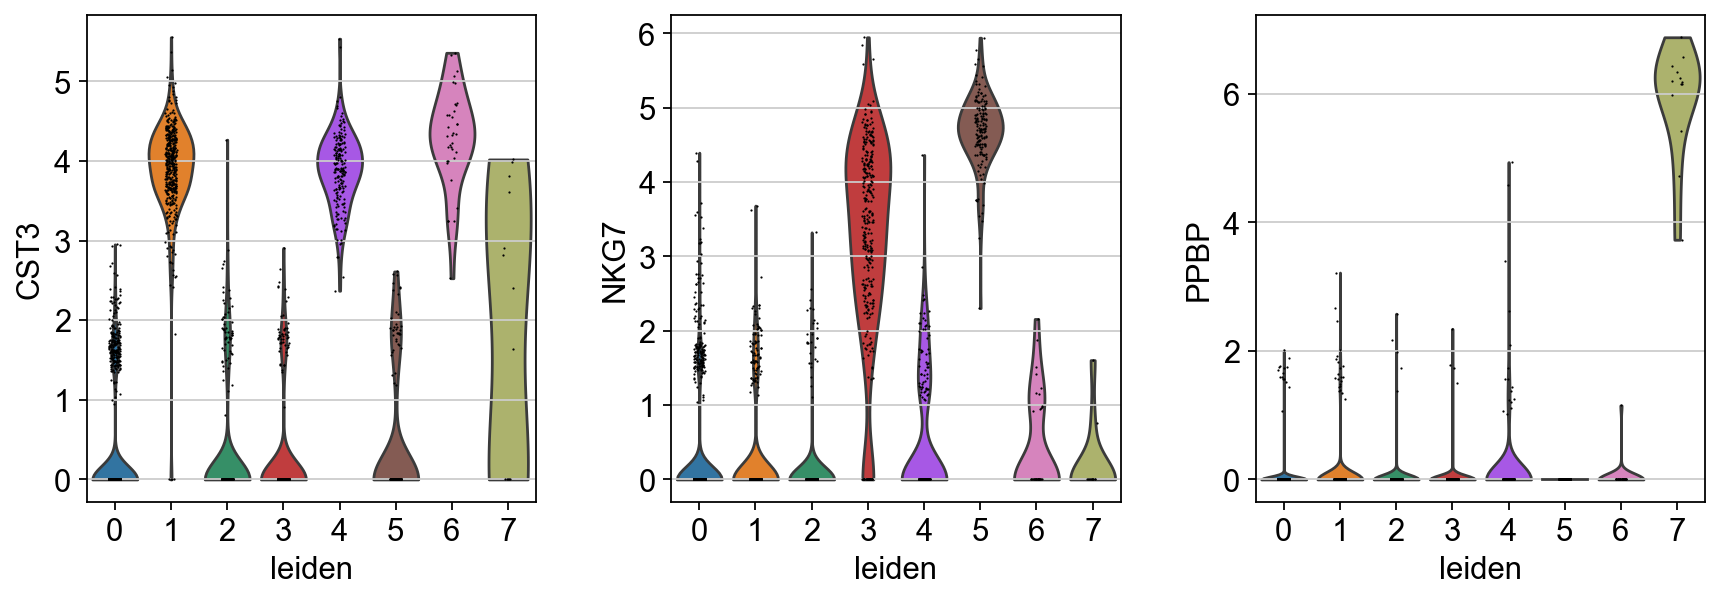

In [150]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [151]:
new_cluster_names = [
    "CD4 T",
    "CD14+ Monocytes",
    "B",
    "CD8 T",
    "FCGR3A+ Monocytes",
    "NK",   
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


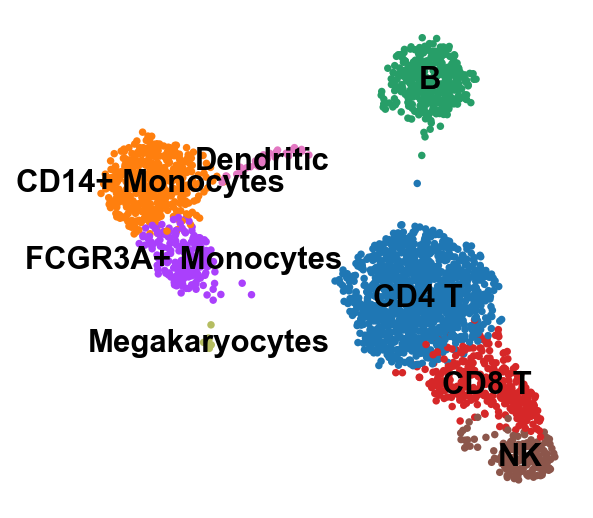

In [152]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


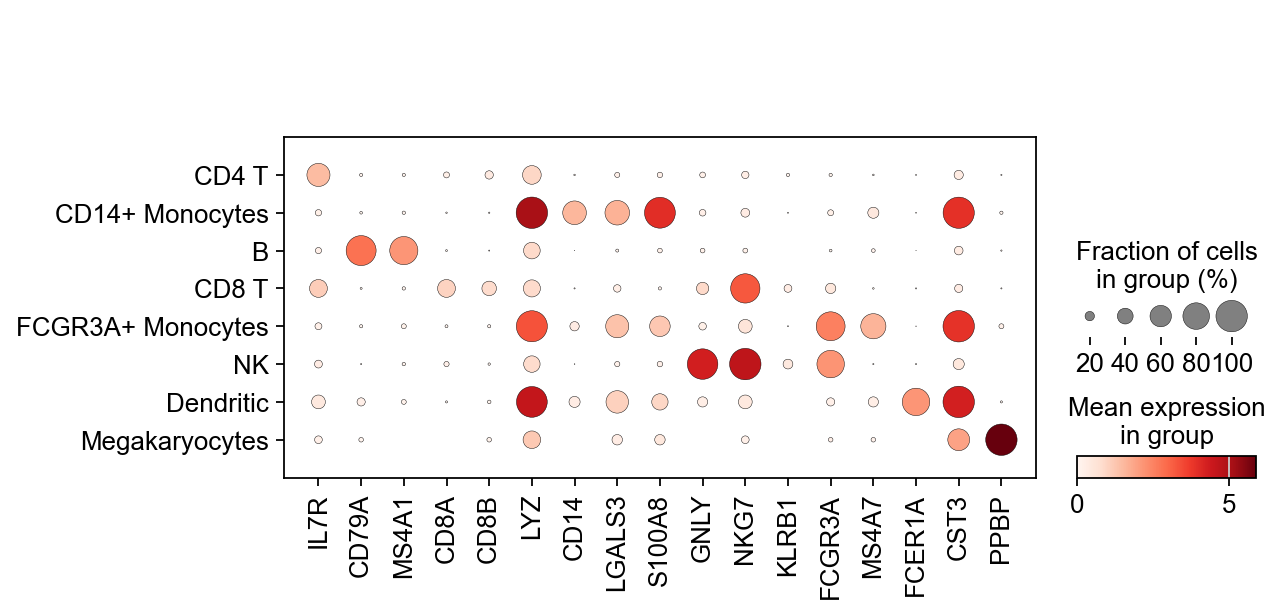

In [153]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden"); #since clusters were numbered differently I need to reorder the labels

/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/Users/paulameena/opt/anaconda3/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is

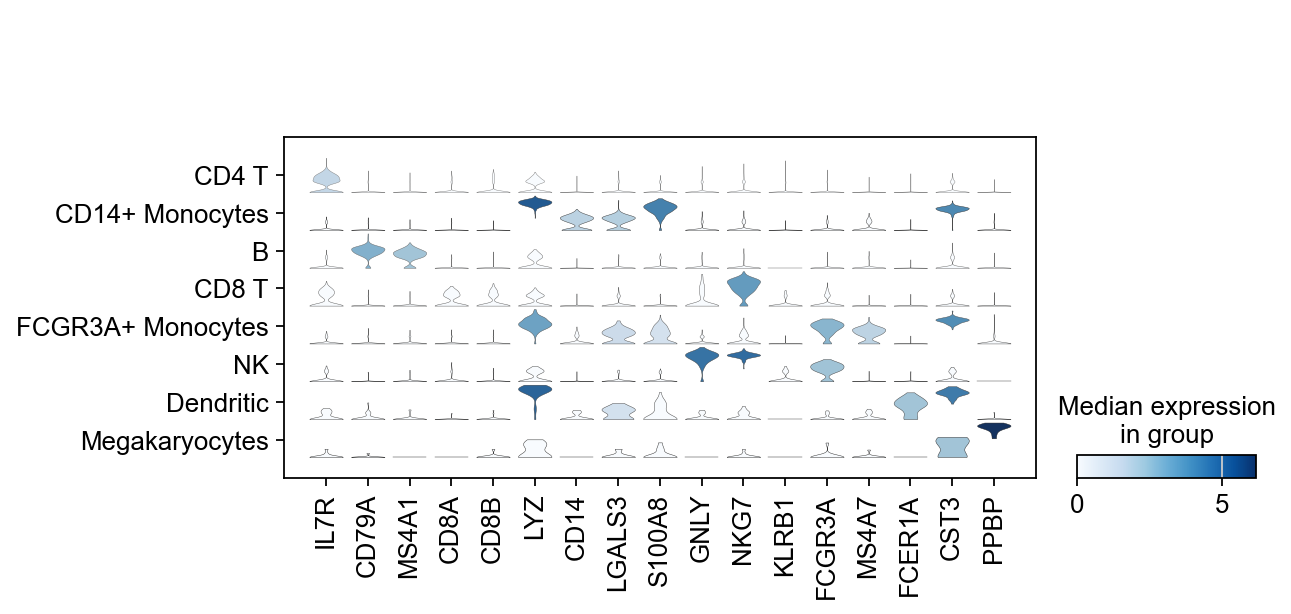

In [154]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");

In [155]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [156]:
adata.write(results_file, compression="gzip")

In [157]:
adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad")